# Proyecto de Predicción de Producción Agrícola 

- IMPORTS

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import adfuller
import itertools

In [3]:
weather_file_path = '/workspaces/proyectfinaltour/data/processed/unificado/weather.csv'
agri_file_path = '/workspaces/proyectfinaltour/data/processed/unificado/agri.csv'

weather_df = pd.read_csv(weather_file_path)
agri_df = pd.read_csv(agri_file_path, encoding='latin1')

In [4]:
#Normalizar los nombres de las columnas en el dataset agrícola
agri_df.columns = agri_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# Crear una columna de fecha en el dataset agrícola
agri_df['date'] = pd.to_datetime(agri_df['año'].astype(str) + '-01-01')

# Crear una columna de fecha en el dataset meteorológico
weather_df['date'] = pd.to_datetime(weather_df['date_time'])

In [5]:

# Mostrar las columnas para verificación
print("Columnas del DataFrame meteorológico:", weather_df.columns)

Columnas del DataFrame meteorológico: Index(['city', 'date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'uvIndex.1', 'moon_illumination', 'moonrise', 'moonset',
       'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph',
       'date'],
      dtype='object')


In [6]:
print("Columnas del DataFrame agrícola:", agri_df.columns)

Columnas del DataFrame agrícola: Index(['año', 'ciudad', 'cultivo', 'superficie_ha', 'produccion_toneladas',
       'date'],
      dtype='object')


- Exploración de Datos
Realizamos una exploración detallada de los datos para entender mejor la estructura y el contenido.

In [7]:
# Ver las primeras filas de los dataframes

print("Primeras filas del DataFrame meteorológico:")
print(weather_df.head())

# Información sobre el DataFrame meteorológico
print("Información del DataFrame meteorológico:")
print(weather_df.info())

#valores nulos en el dataframe meteorológico
print("Valores nulos en el DataFrame meteorológico:")
print(weather_df.isnull().sum())

Primeras filas del DataFrame meteorológico:
        city   date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0  Barcelona  2008-07-01        27        22           0.0     14.5        6   
1  Barcelona  2008-07-02        25        19           0.0     14.5        6   
2  Barcelona  2008-07-03        25        20           0.0     14.5        6   
3  Barcelona  2008-07-04        25        19           0.0     14.5        6   
4  Barcelona  2008-07-05        27        20           0.0     14.5        6   

   uvIndex.1  moon_illumination  moonrise  ... WindGustKmph cloudcover  \
0          6                  4  04:04 AM  ...           19          8   
1          6                  0  05:07 AM  ...           11          6   
2          6                  0  06:21 AM  ...           14         22   
3          6                  3  07:41 AM  ...           22          5   
4          6                 10  08:59 AM  ...           18          5   

  humidity  precipMM  pressure

In [8]:
# Primeras filas del DataFrame Agrícola
print("Primeras filas del DataFrame agrícola:")
print(agri_df.head())

# Información sobre el DataFrame agrícola
print("Información del DataFrame agrícola:")
print(agri_df.info())

# Verificar la existencia de valores nulos en el dataframe agrícola
print("Valores nulos en el DataFrame agrícola:")
print(agri_df.isnull().sum())

Primeras filas del DataFrame agrícola:
    año     ciudad cultivo  superficie_ha  produccion_toneladas       date
0  2008     Madrid   Trigo           1500                  3000 2008-01-01
1  2008  Barcelona   MaÃ­z           1200                  2500 2008-01-01
2  2008    Sevilla   Olivo           2000                  4000 2008-01-01
3  2008   Valencia     Vid           1800                  3500 2008-01-01
4  2008     Bilbao   Trigo           1100                  2200 2008-01-01
Información del DataFrame agrícola:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   año                   88 non-null     int64         
 1   ciudad                88 non-null     object        
 2   cultivo               88 non-null     object        
 3   superficie_ha         88 non-null     int64         
 4   produccion_toneladas

- Limpieza y Preparación de Datos: 

In [9]:
# Llenar o eliminar valores nulos si existen
agri_df = agri_df.ffill()
weather_df = weather_df.ffill()

# Crear una columna de fecha en el dataset agrícola
agri_df['date'] = pd.to_datetime(agri_df['año'].astype(str) + '-01-01')

# Crear una columna de fecha en el dataset meteorológico
weather_df['date'] = pd.to_datetime(weather_df['date_time'])

# Verificar las ciudades en ambos conjuntos de datos
agri_df['ciudad'] = agri_df['ciudad'].str.strip().str.lower()
weather_df['city'] = weather_df['city'].str.strip().str.lower()

# Crear las columnas de `year` y `month` en el dataset meteorológico
weather_df['year'] = pd.DatetimeIndex(weather_df['date']).year
weather_df['month'] = pd.DatetimeIndex(weather_df['date']).month

# Unir los datos agrícolas y meteorológicos por año y ciudad
combined_df = pd.merge(agri_df, weather_df, left_on=['año', 'ciudad'], right_on=['year', 'city'], how='inner')

# Mostrar los nombres de las columnas en el DataFrame combinado
print("Columnas del DataFrame combinado:", combined_df.columns)

# Seleccionar las columnas relevantes (verificar los nombres correctos)
data = combined_df[['ciudad', 'date_y', 'produccion_toneladas', 'tempC', 'uvIndex', 'precipMM', 'sunHour']]

# Crear columnas para el año y el mes
data['year'] = pd.DatetimeIndex(data['date_y']).year
data['month'] = pd.DatetimeIndex(data['date_y']).month

# Calcular las medias mensuales de las variables de interés
monthly_means = data.groupby(['ciudad', 'year', 'month']).agg({
    'tempC': 'mean',
    'uvIndex': 'mean',
    'precipMM': 'mean',
    'sunHour': 'mean',
    'produccion_toneladas': 'mean'
}).reset_index()

# Crear una columna de fecha para la serie temporal
monthly_means['date'] = pd.to_datetime(monthly_means[['year', 'month']].assign(day=1))

# Establecer la columna de fecha como índice
monthly_means.set_index('date', inplace=True)

# Ordenar los datos por fecha
monthly_means.sort_index(inplace=True)

Columnas del DataFrame combinado: Index(['año', 'ciudad', 'cultivo', 'superficie_ha', 'produccion_toneladas',
       'date_x', 'city', 'date_time', 'maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'uvIndex.1', 'moon_illumination', 'moonrise',
       'moonset', 'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph',
       'date_y', 'year', 'month'],
      dtype='object')


/tmp/ipykernel_13123/4080270853.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = pd.DatetimeIndex(data['date_y']).year
/tmp/ipykernel_13123/4080270853.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = pd.DatetimeIndex(data['date_y']).month


## Análisis Descriptivo y Visualización

Realizar un análisis descriptivo de los datos y visualizaciones para entender las relaciones entre las variables.


Análisis descriptivo de las variables agrícolas:
             año  superficie_ha  produccion_toneladas  \
count    88.0000      88.000000             88.000000   
mean   2013.0000    1497.727273           2963.636364   
min    2008.0000     900.000000           1800.000000   
25%    2010.0000    1237.500000           2500.000000   
50%    2013.0000    1412.500000           2825.000000   
75%    2016.0000    1725.000000           3425.000000   
max    2018.0000    2200.000000           4400.000000   
std       3.1804     365.141217            699.290579   

                                date  
count                             88  
mean   2012-12-31 15:16:21.818181888  
min              2008-01-01 00:00:00  
25%              2010-01-01 00:00:00  
50%              2013-01-01 00:00:00  
75%              2016-01-01 00:00:00  
max              2018-01-01 00:00:00  
std                              NaN  
Análisis descriptivo de las variables meteorológicas:
           maxtempC      mintemp

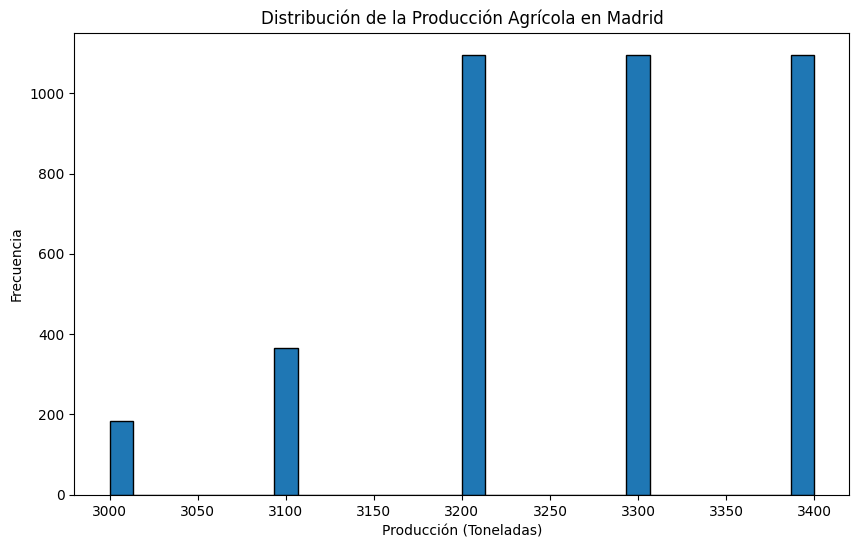

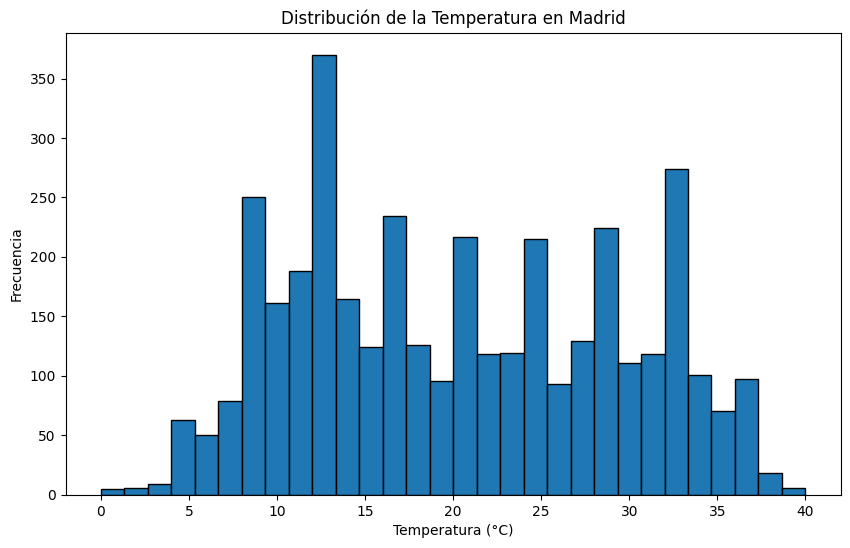

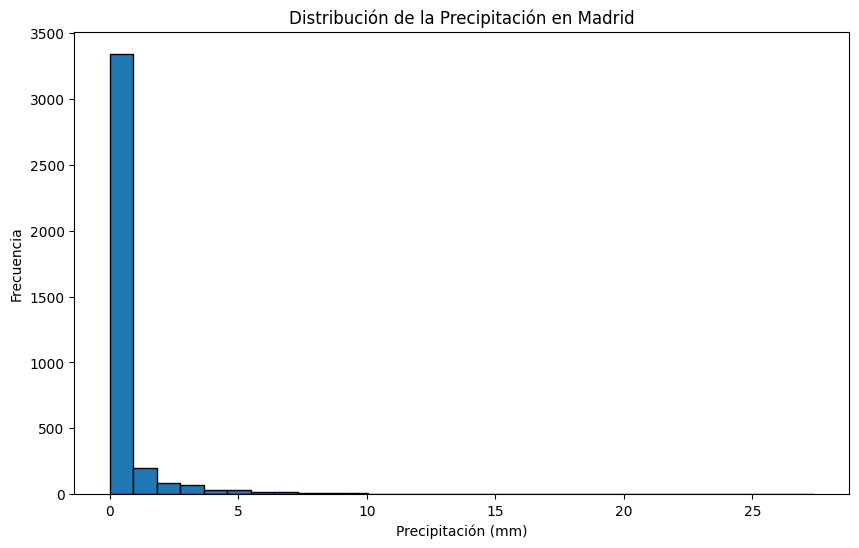

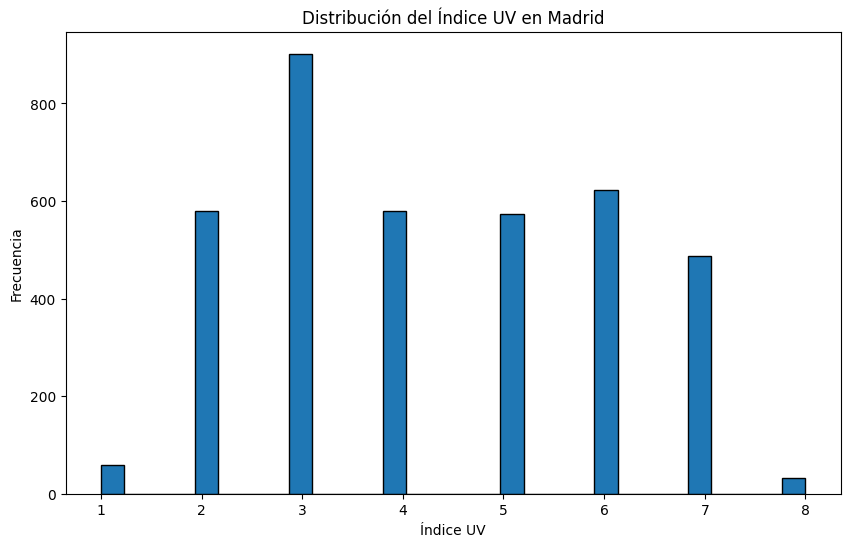

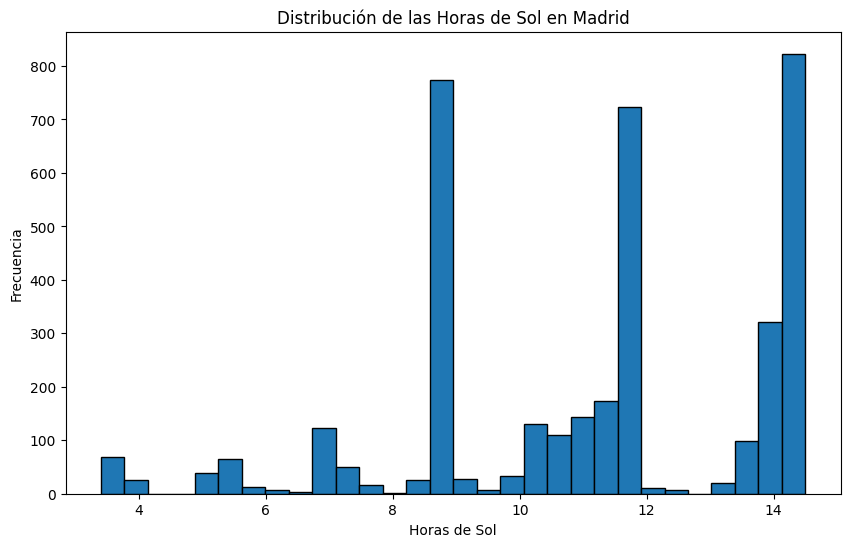

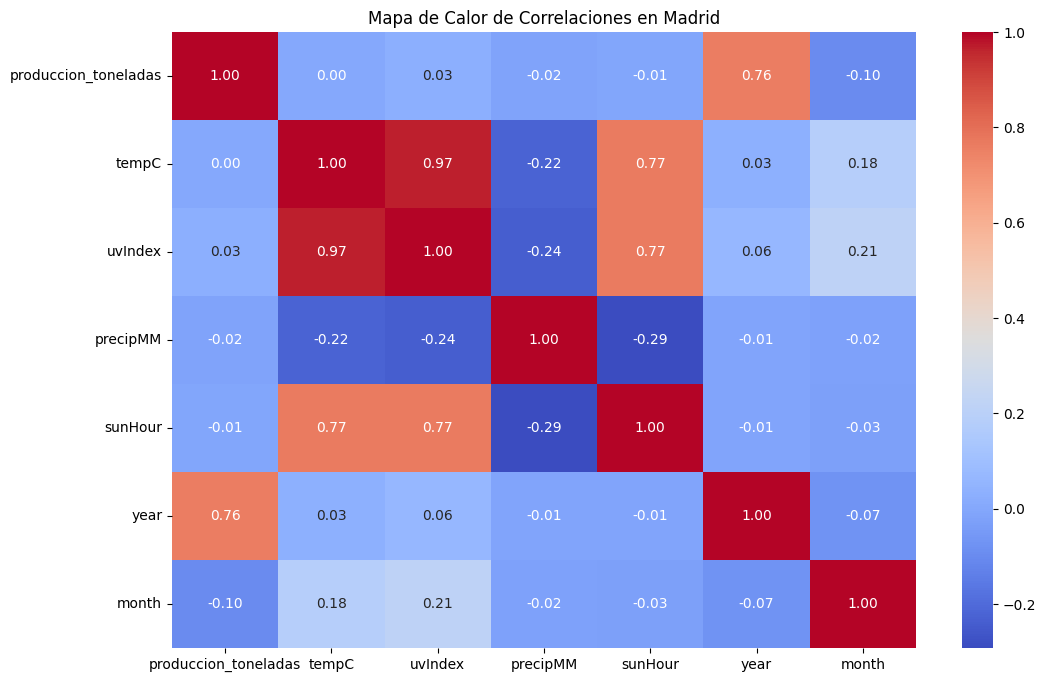

Análisis descriptivo para Barcelona:
                              date_y  produccion_toneladas        tempC  \
count                           3836           3836.000000  3836.000000   
mean   2013-09-30 11:59:59.999999744           2633.302920    19.330292   
min              2008-07-01 00:00:00           2500.000000     4.000000   
25%              2011-02-14 18:00:00           2600.000000    14.000000   
50%              2013-09-30 12:00:00           2650.000000    19.000000   
75%              2016-05-16 06:00:00           2700.000000    24.000000   
max              2018-12-31 00:00:00           2700.000000    34.000000   
std                              NaN             56.397851     5.959632   

           uvIndex     precipMM      sunHour         year        month  
count  3836.000000  3836.000000  3836.000000  3836.000000  3836.000000  
mean      4.630083     0.874765    11.003363  2013.236444     6.666058  
min       1.000000     0.000000     3.400000  2008.000000     1.0000

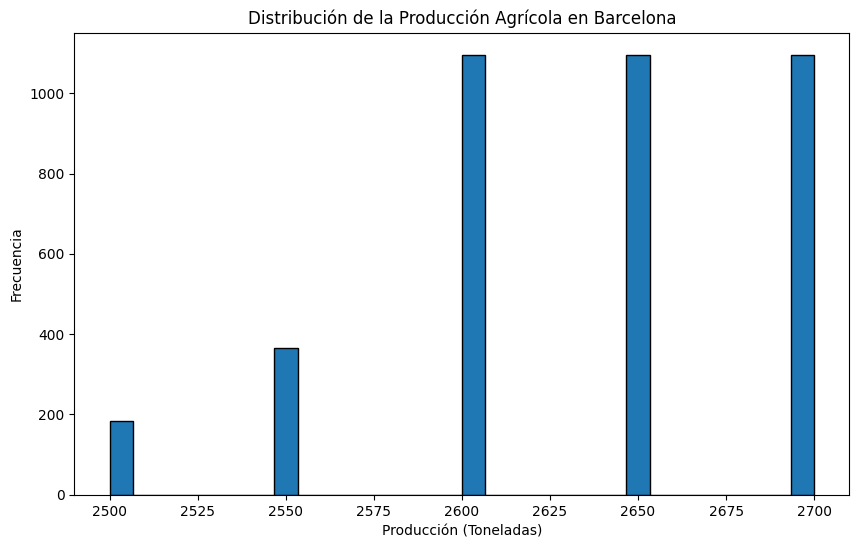

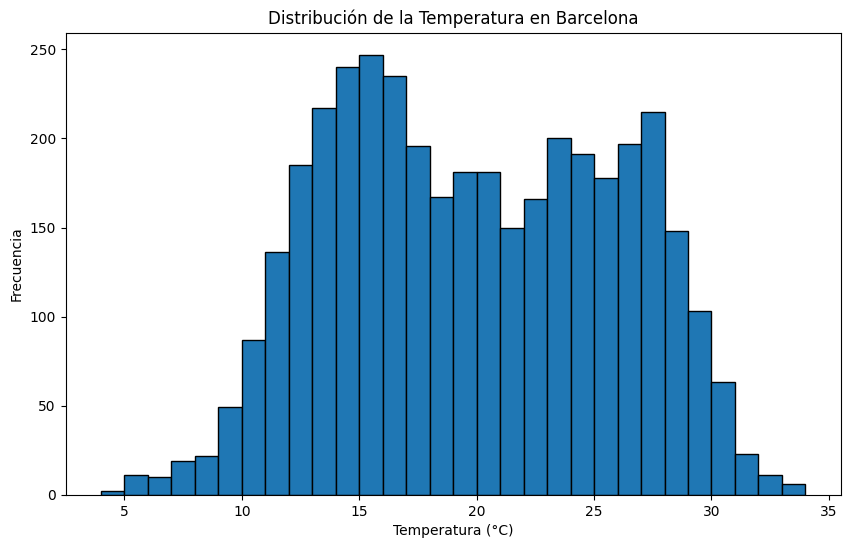

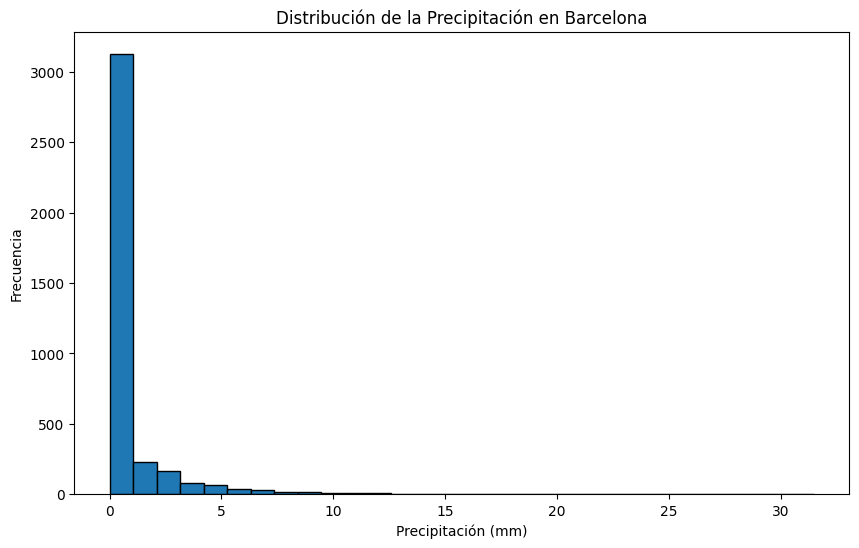

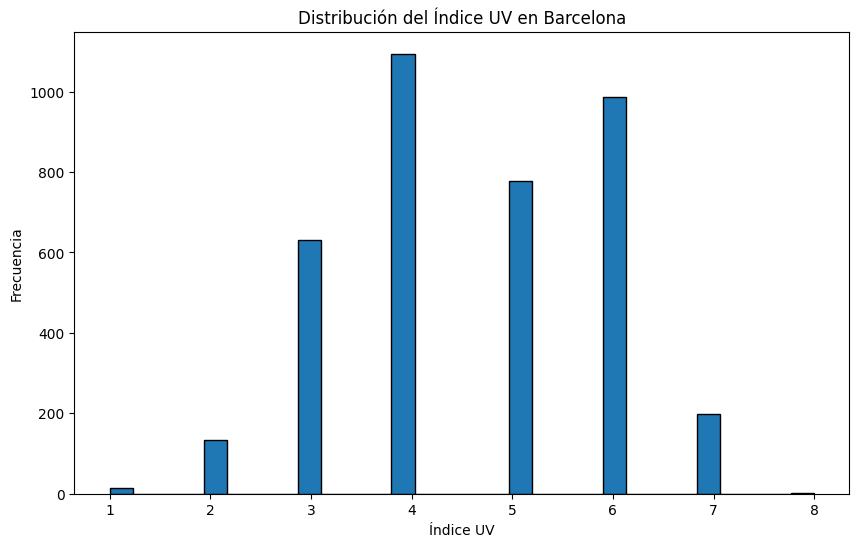

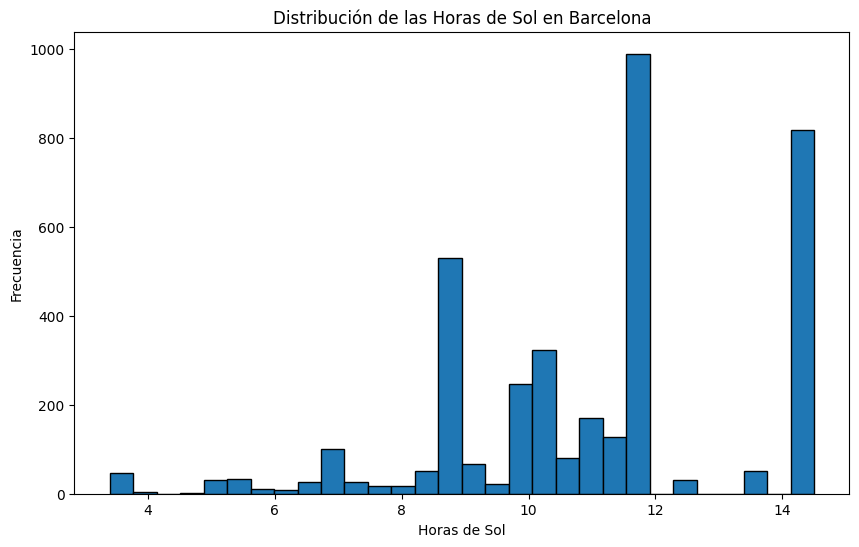

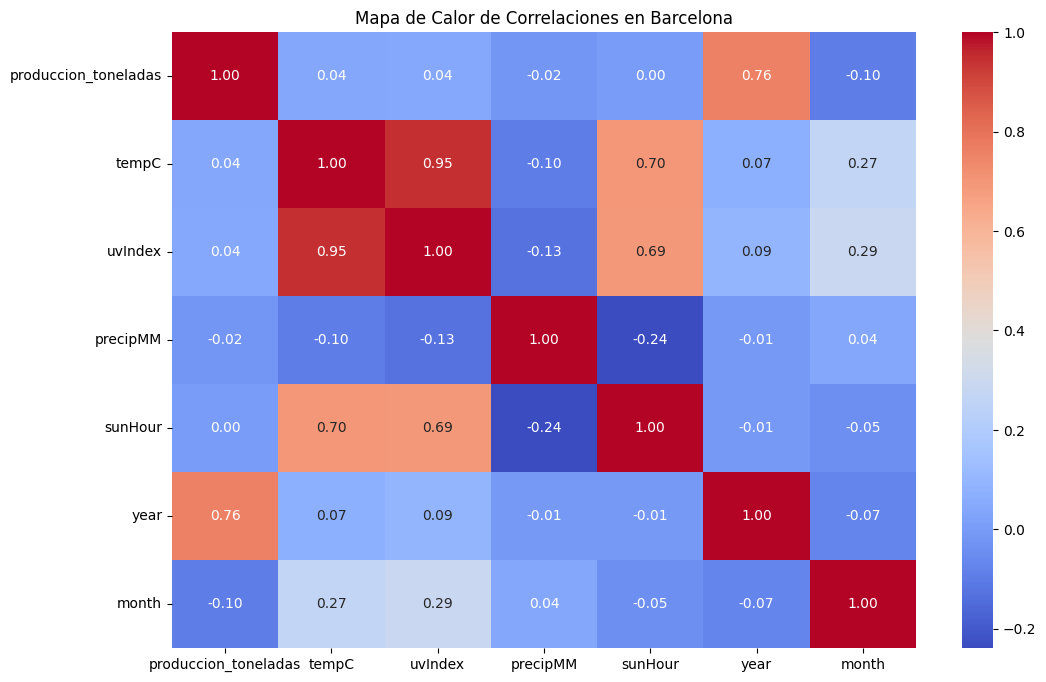

Análisis descriptivo para Sevilla:
                              date_y  produccion_toneladas        tempC  \
count                           3836           3836.000000  3836.000000   
mean   2013-09-30 11:59:59.999999744           4266.605839    25.196559   
min              2008-07-01 00:00:00           4000.000000     3.000000   
25%              2011-02-14 18:00:00           4200.000000    18.000000   
50%              2013-09-30 12:00:00           4300.000000    24.000000   
75%              2016-05-16 06:00:00           4400.000000    33.000000   
max              2018-12-31 00:00:00           4400.000000    45.000000   
std                              NaN            112.795702     8.637805   

           uvIndex     precipMM      sunHour         year        month  
count  3836.000000  3836.000000  3836.000000  3836.000000  3836.000000  
mean      5.123045     0.649922    11.007325  2013.236444     6.666058  
min       1.000000     0.000000     3.700000  2008.000000     1.000000

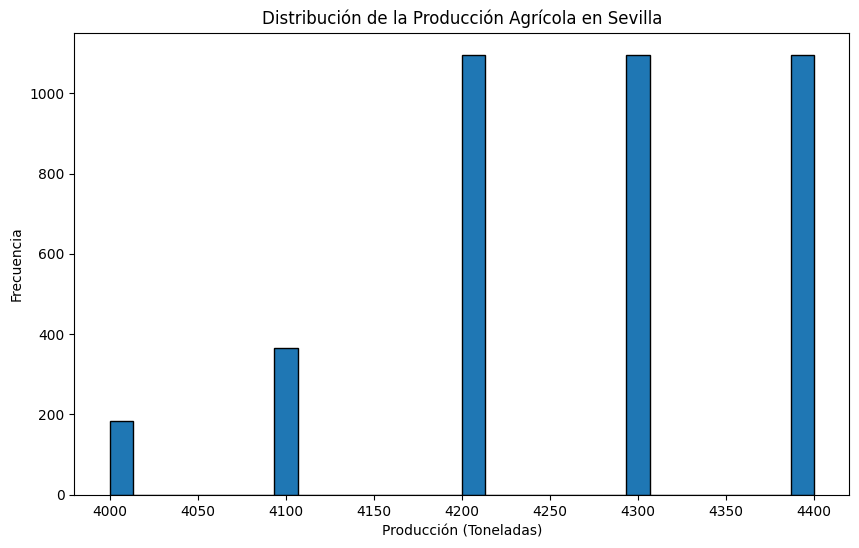

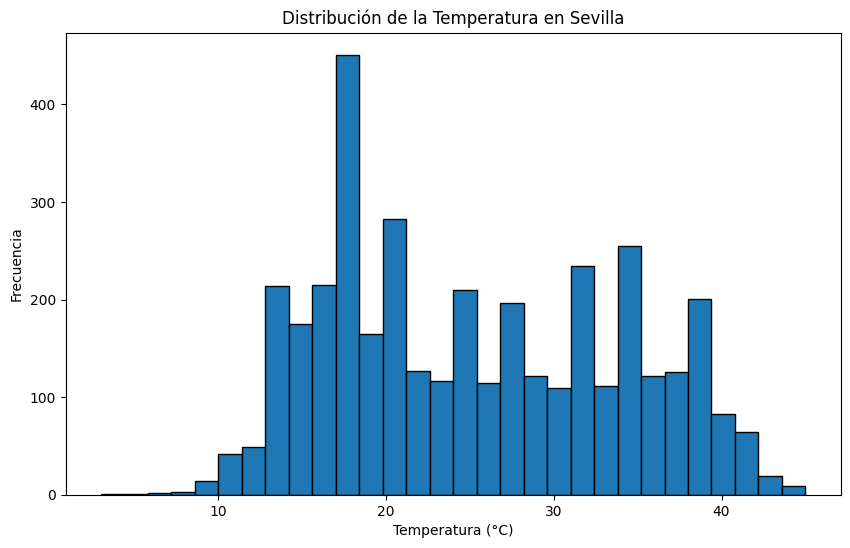

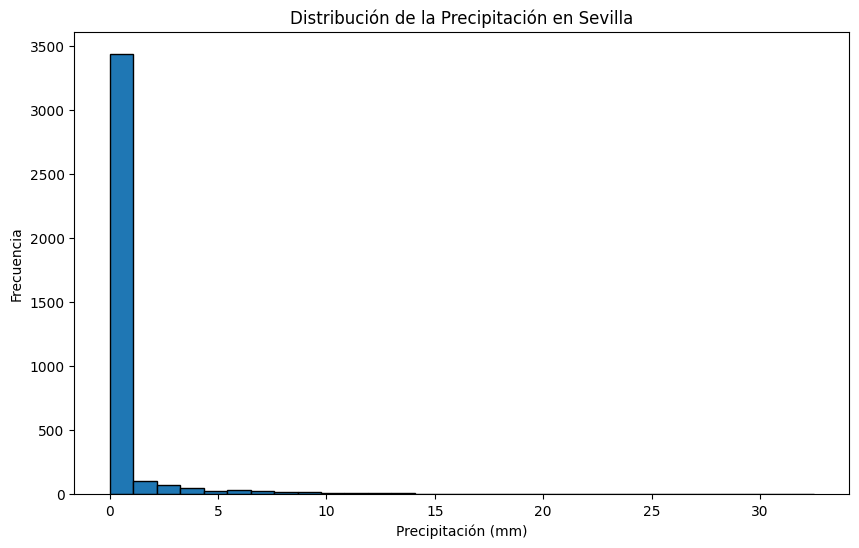

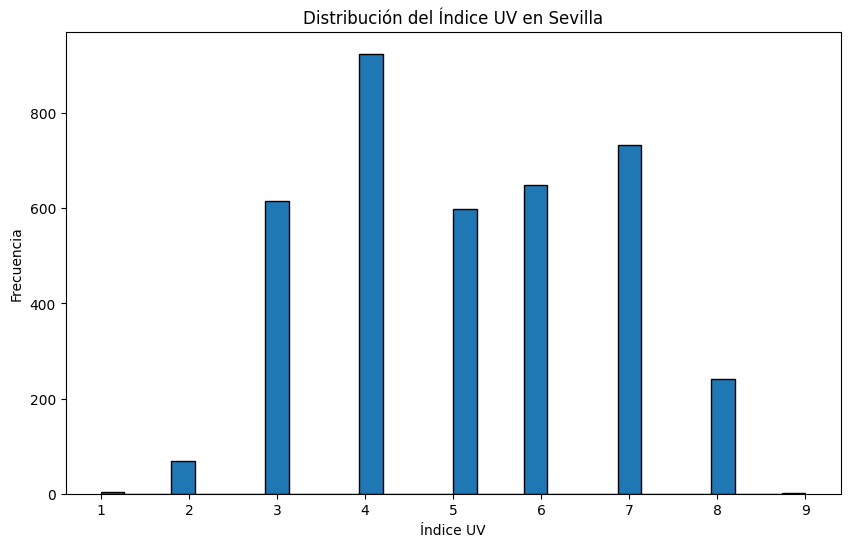

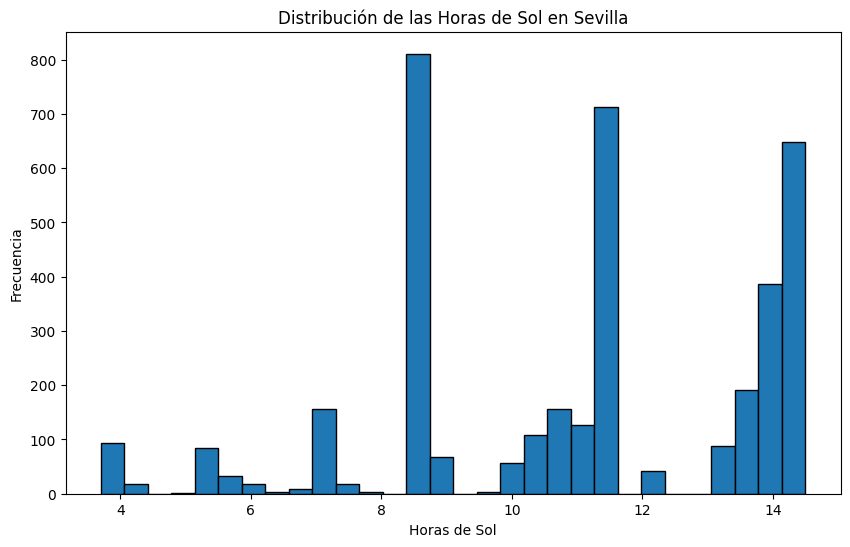

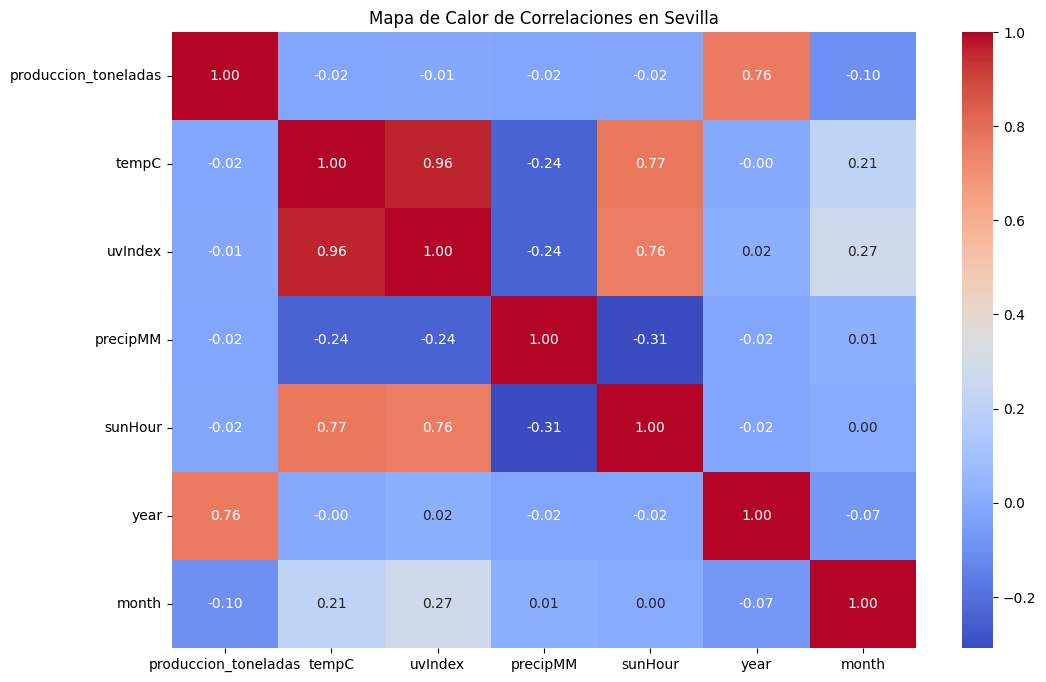

Análisis descriptivo para Valencia:
                              date_y  produccion_toneladas        tempC  \
count                           3836           3836.000000  3836.000000   
mean   2013-09-30 11:59:59.999999744           3633.302920    28.305787   
min              2008-07-01 00:00:00           3500.000000    21.000000   
25%              2011-02-14 18:00:00           3600.000000    27.000000   
50%              2013-09-30 12:00:00           3650.000000    28.000000   
75%              2016-05-16 06:00:00           3700.000000    29.000000   
max              2018-12-31 00:00:00           3700.000000    35.000000   
std                              NaN             56.397851     1.789751   

           uvIndex     precipMM      sunHour         year        month  
count  3836.000000  3836.000000  3836.000000  3836.000000  3836.000000  
mean      6.086288     2.291215    11.105996  2013.236444     6.666058  
min       5.000000     0.000000     5.900000  2008.000000     1.00000

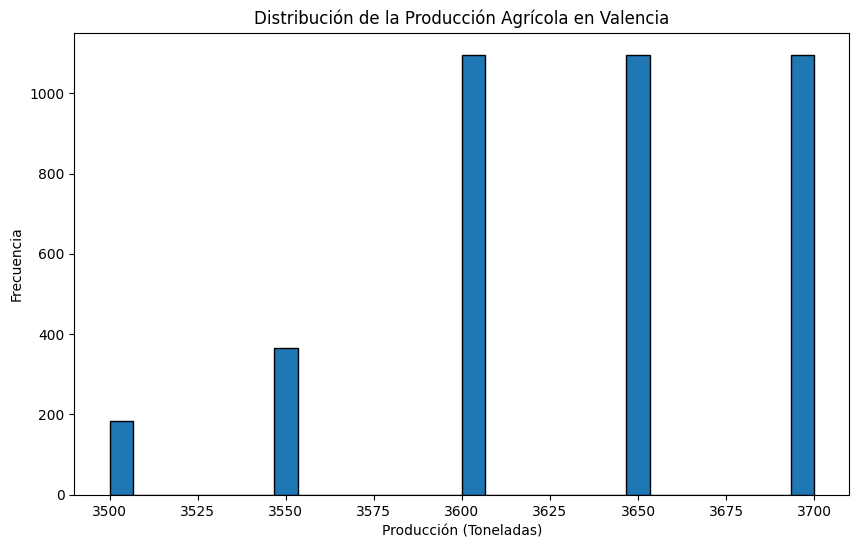

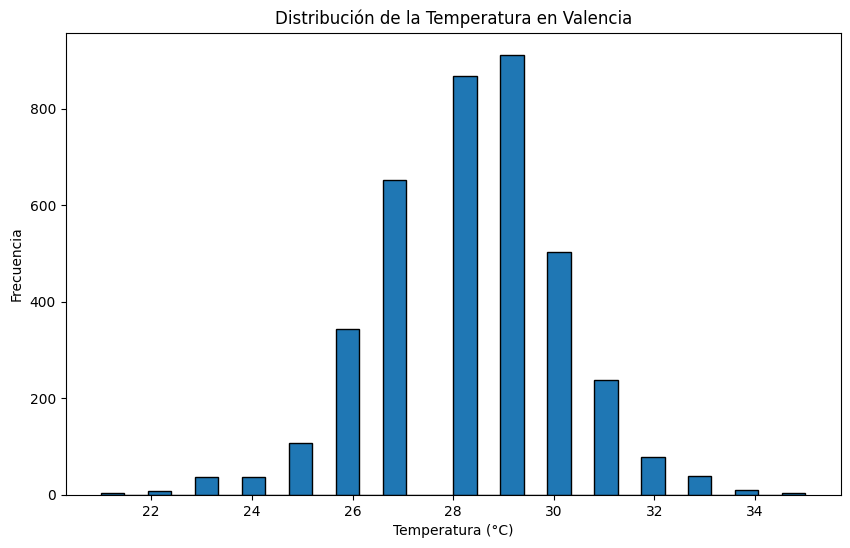

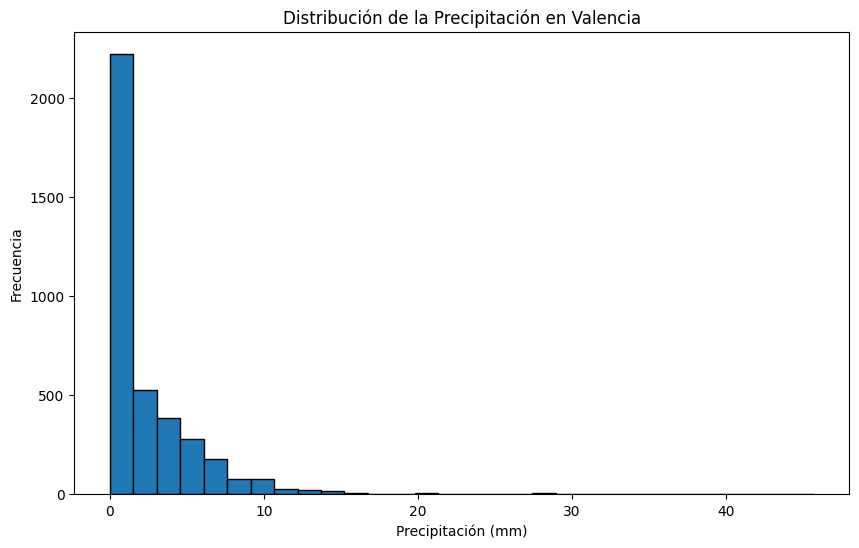

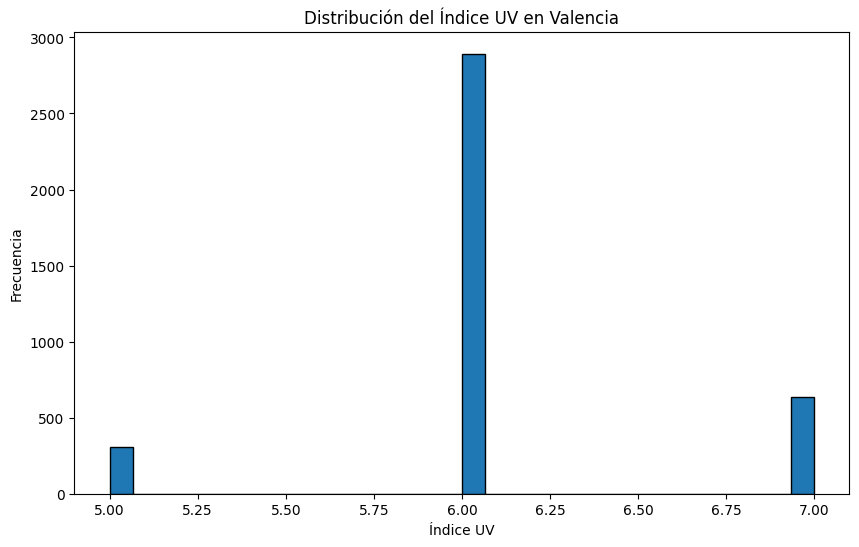

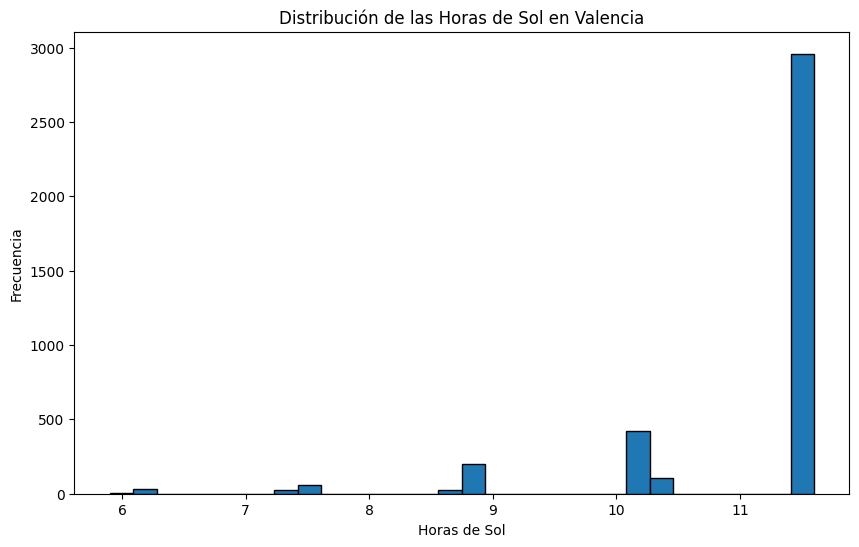

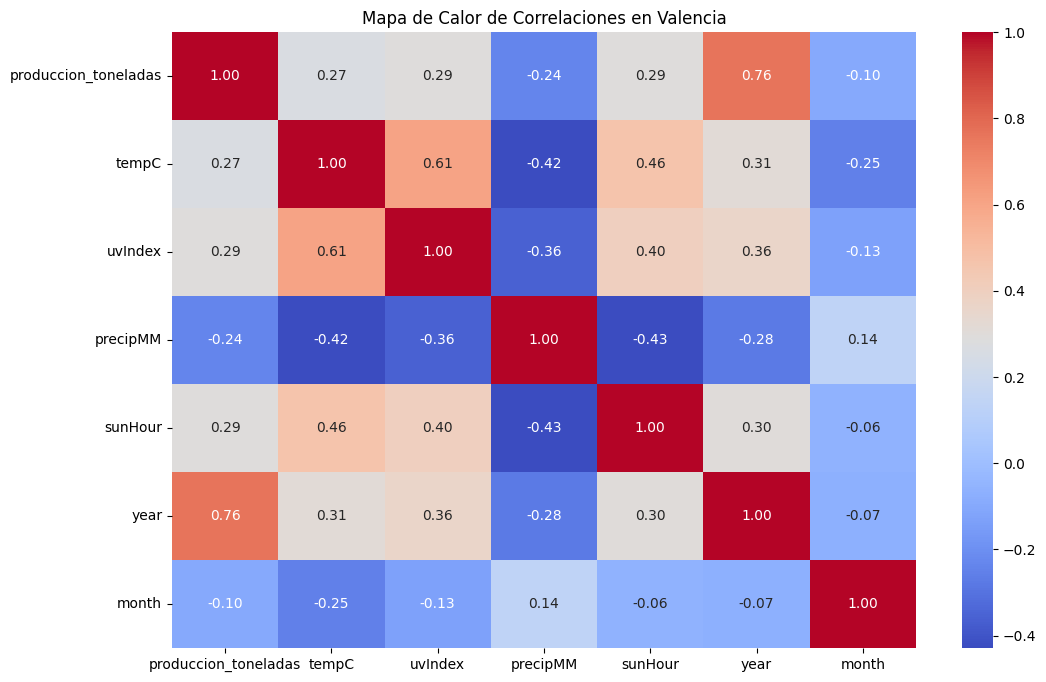

Análisis descriptivo para Bilbao:
                              date_y  produccion_toneladas        tempC  \
count                           3836            3836.00000  3836.000000   
mean   2013-09-30 11:59:59.999999744            2342.81804    16.355839   
min              2008-07-01 00:00:00            2200.00000     1.000000   
25%              2011-02-14 18:00:00            2300.00000    12.000000   
50%              2013-09-30 12:00:00            2350.00000    16.000000   
75%              2016-05-16 06:00:00            2400.00000    21.000000   
max              2018-12-31 00:00:00            2500.00000    33.000000   
std                              NaN              72.88010     5.434864   

           uvIndex     precipMM      sunHour         year        month  
count  3836.000000  3836.000000  3836.000000  3836.000000  3836.000000  
mean      3.960897     1.380709    10.207091  2013.236444     6.666058  
min       1.000000     0.000000     3.400000  2008.000000     1.000000 

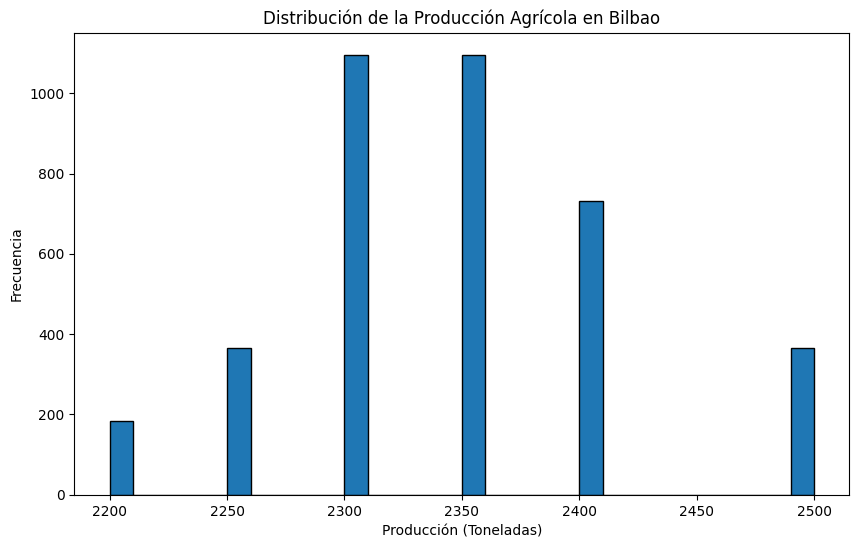

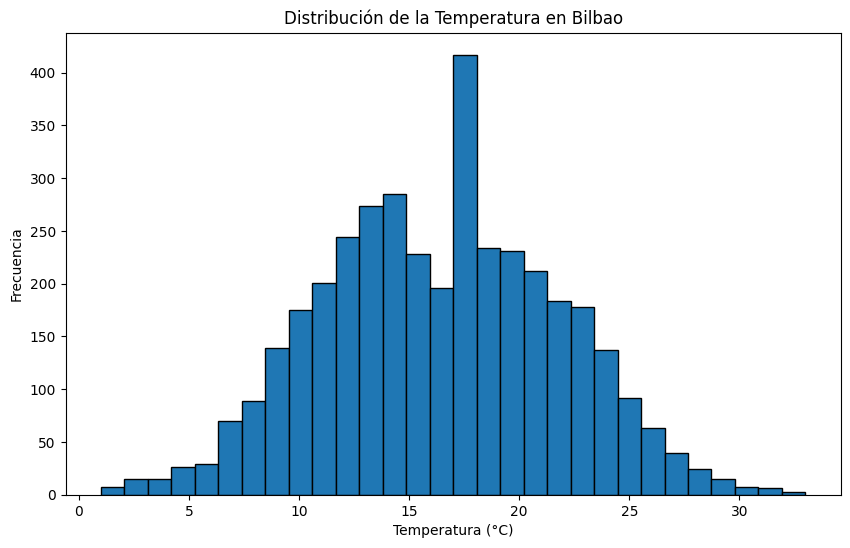

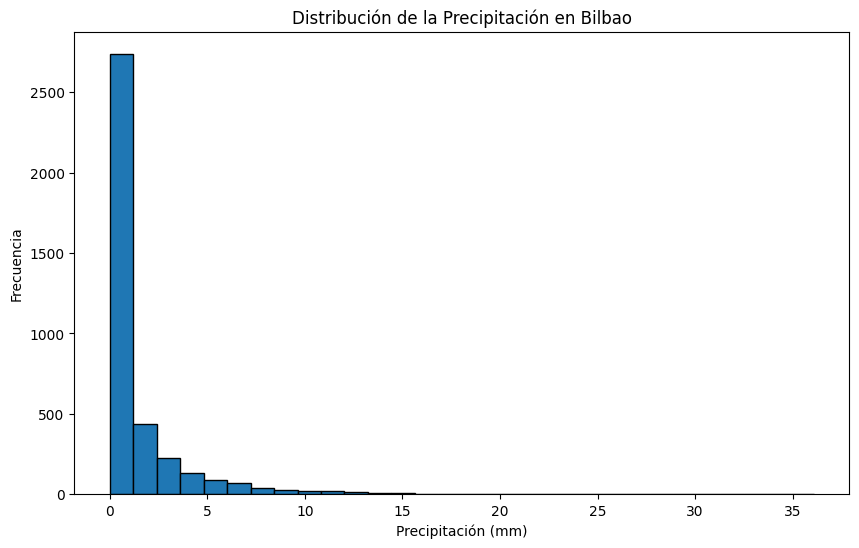

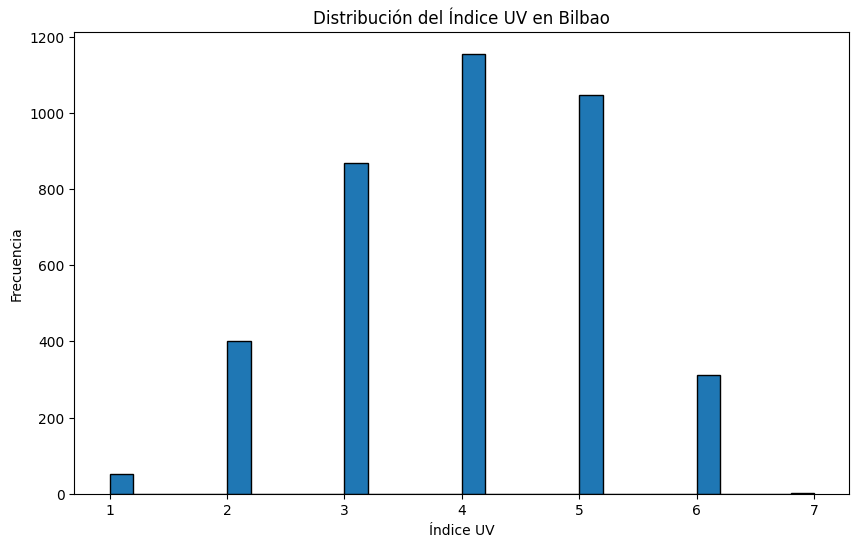

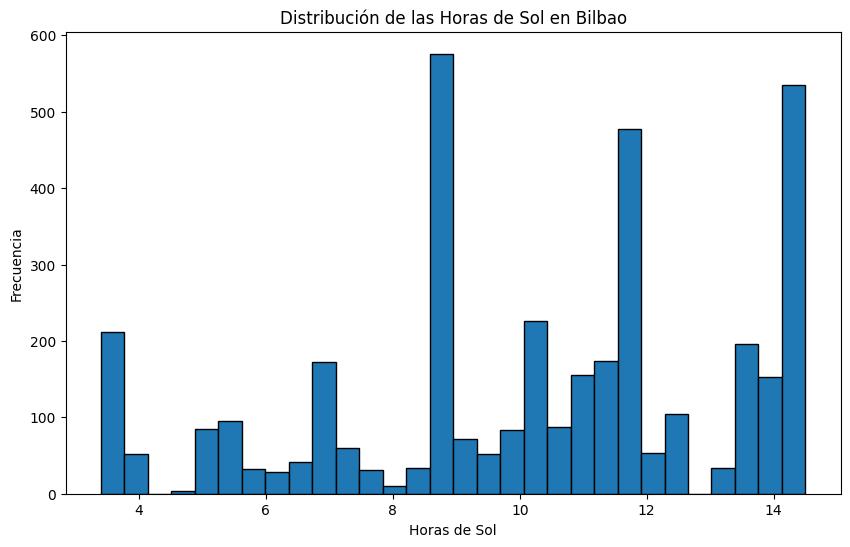

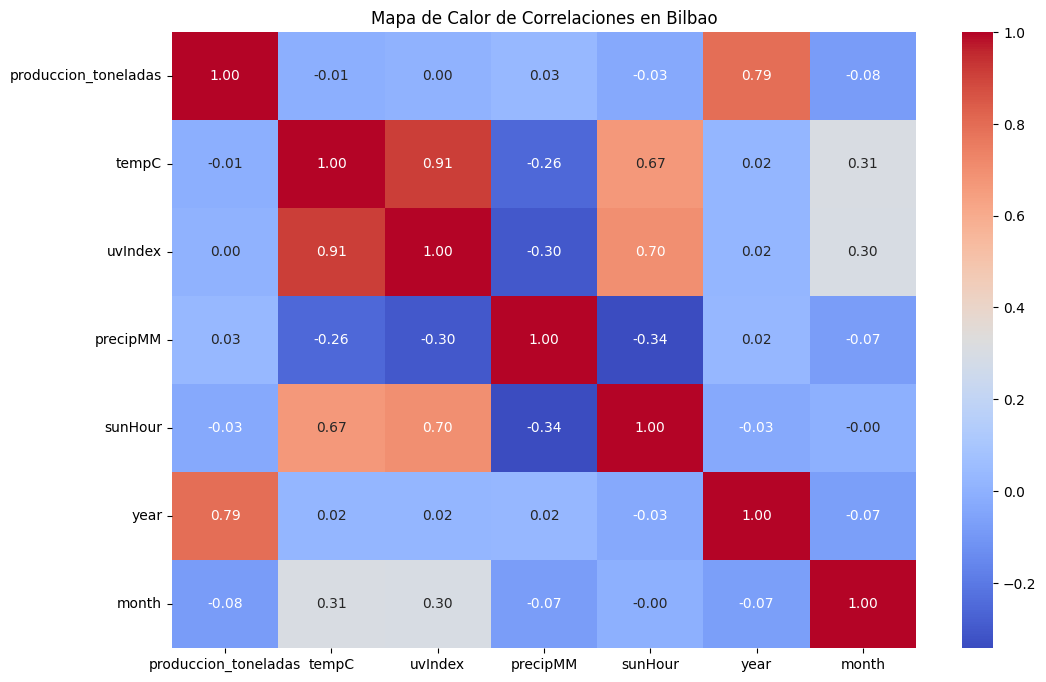

Análisis descriptivo para Vigo:
                              date_y  produccion_toneladas        tempC  \
count                           3836            3836.00000  3836.000000   
mean   2013-09-30 11:59:59.999999744            1942.81804    17.469239   
min              2008-07-01 00:00:00            1800.00000     4.000000   
25%              2011-02-14 18:00:00            1900.00000    13.000000   
50%              2013-09-30 12:00:00            1950.00000    17.000000   
75%              2016-05-16 06:00:00            2000.00000    22.000000   
max              2018-12-31 00:00:00            2100.00000    33.000000   
std                              NaN              72.88010     5.416026   

           uvIndex     precipMM      sunHour         year        month  
count  3836.000000  3836.000000  3836.000000  3836.000000  3836.000000  
mean      4.005996     2.210819    10.333160  2013.236444     6.666058  
min       1.000000     0.000000     3.400000  2008.000000     1.000000  


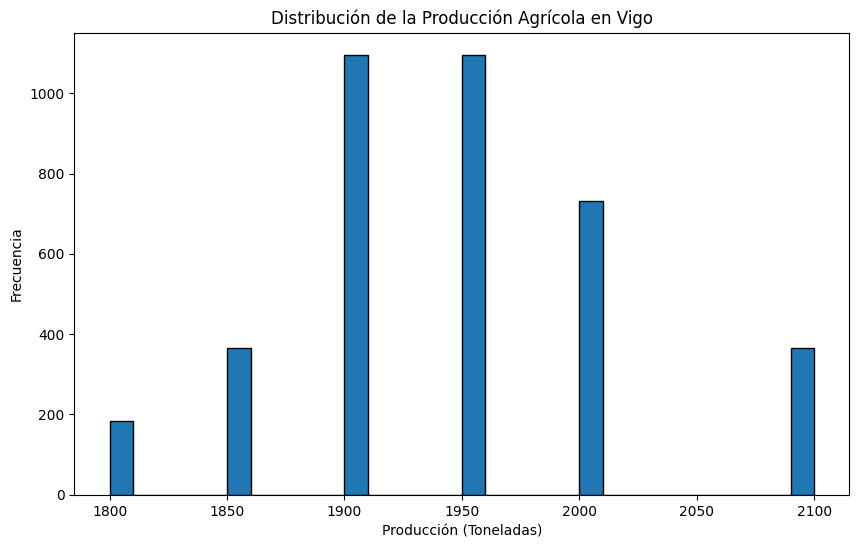

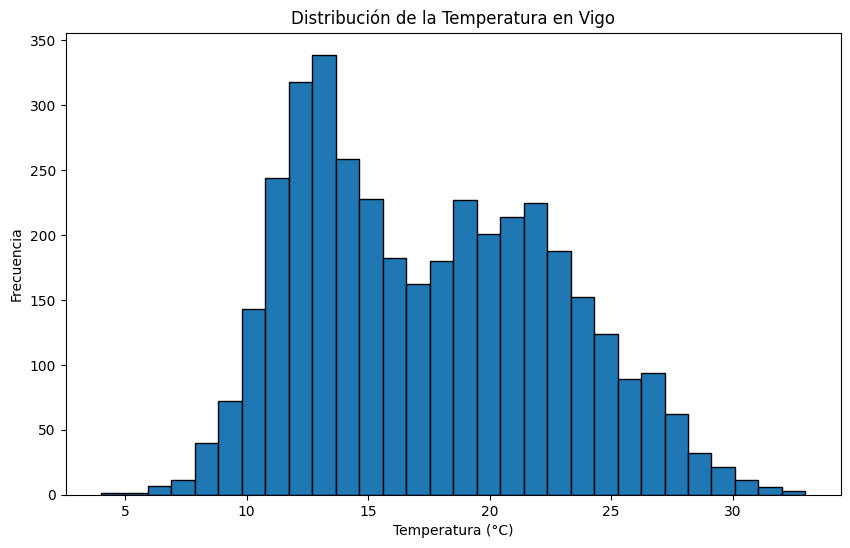

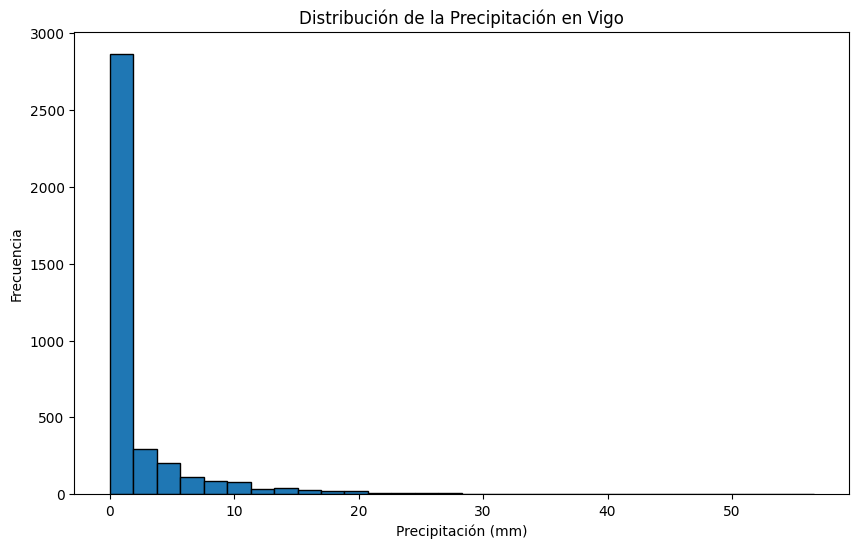

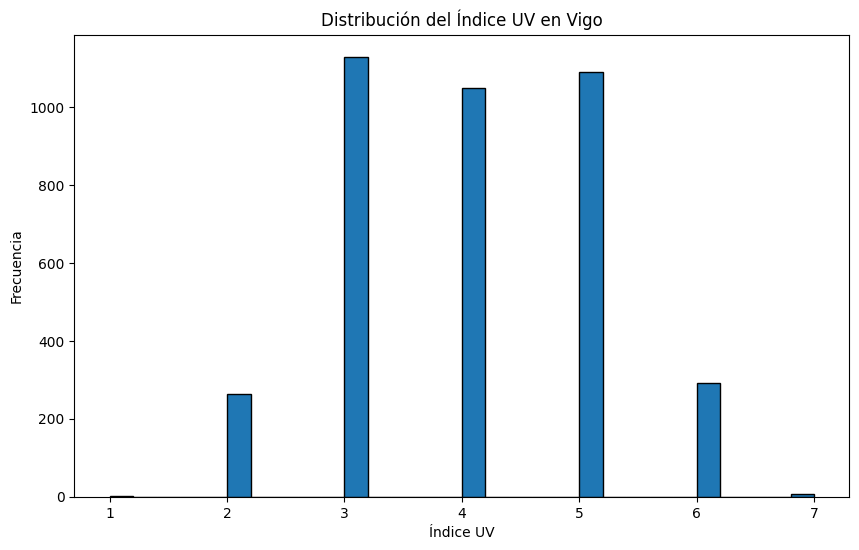

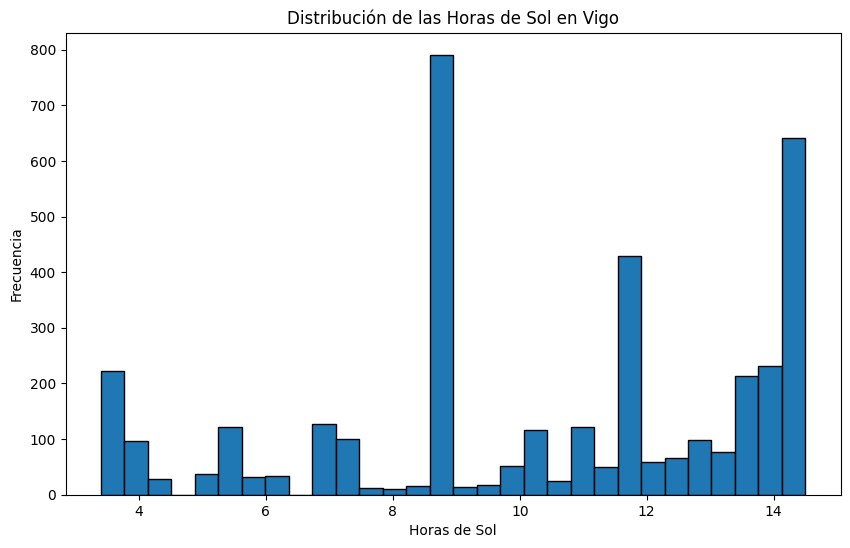

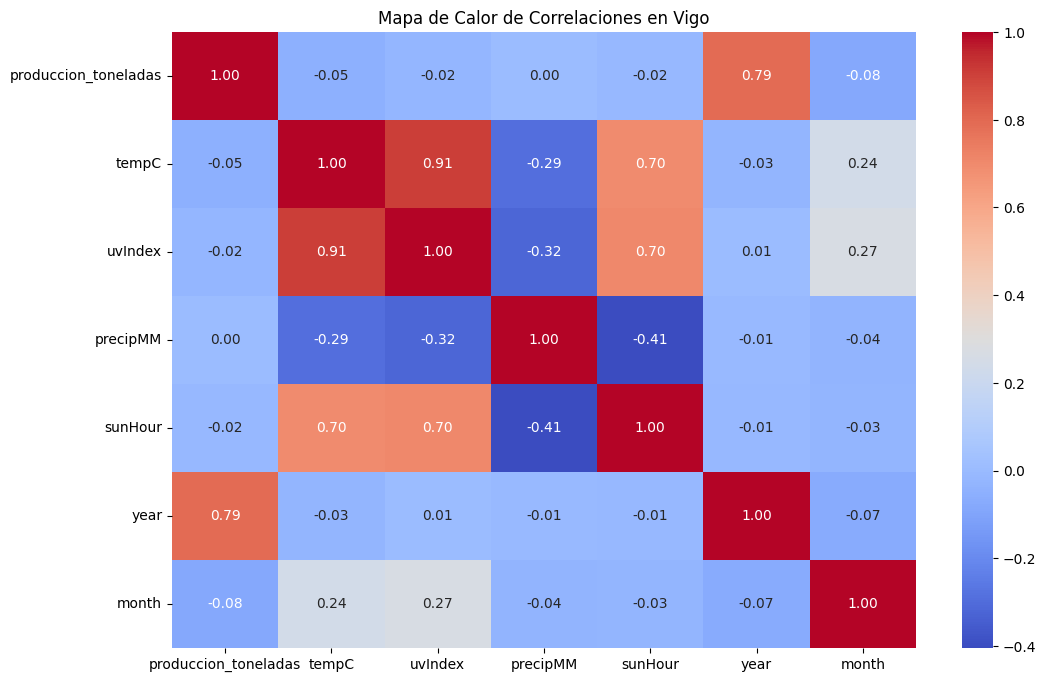

Análisis descriptivo para Oporto:
                              date_y  produccion_toneladas        tempC  \
count                           3836            3836.00000  3836.000000   
mean   2013-09-30 11:59:59.999999744            2742.81804    24.531022   
min              2008-07-01 00:00:00            2600.00000     5.000000   
25%              2011-02-14 18:00:00            2700.00000    20.000000   
50%              2013-09-30 12:00:00            2750.00000    25.000000   
75%              2016-05-16 06:00:00            2800.00000    29.000000   
max              2018-12-31 00:00:00            2900.00000    40.000000   
std                              NaN              72.88010     5.658129   

           uvIndex     precipMM      sunHour         year        month  
count  3836.000000  3836.000000  3836.000000  3836.000000  3836.000000  
mean      5.082117     1.754093    10.186913  2013.236444     6.666058  
min       2.000000     0.000000     3.800000  2008.000000     1.000000 

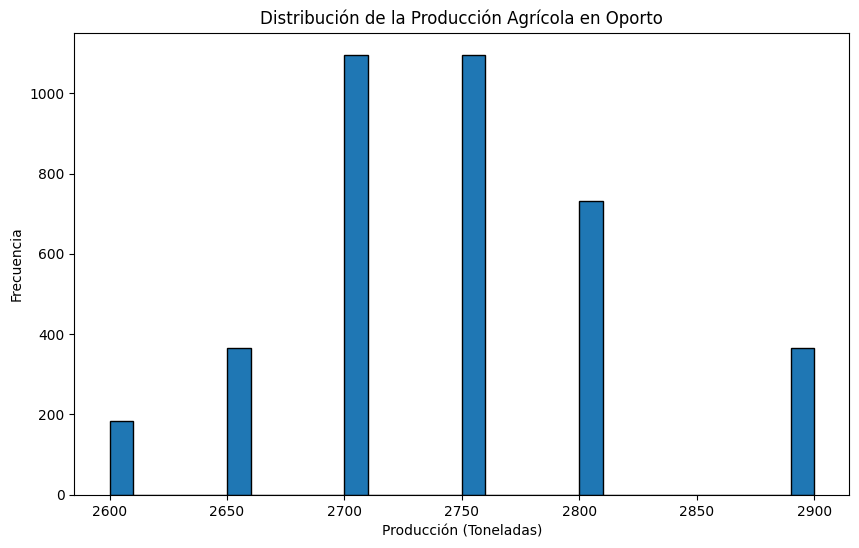

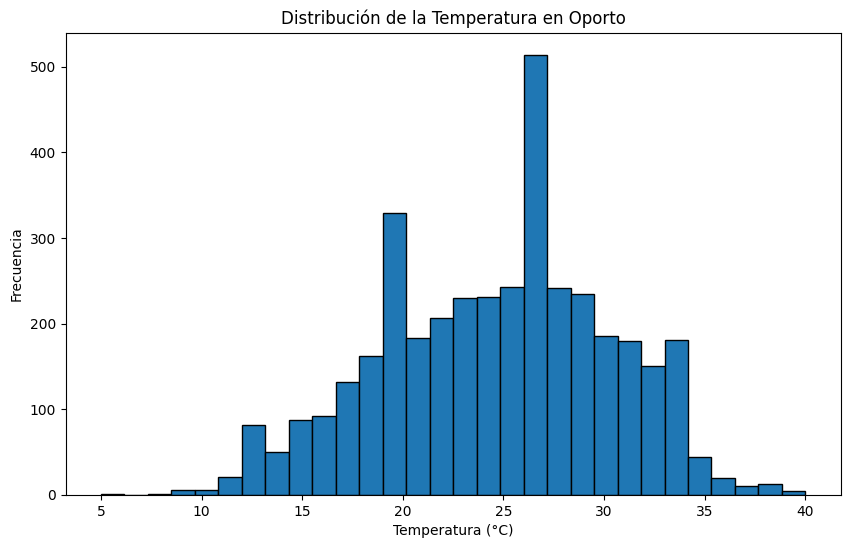

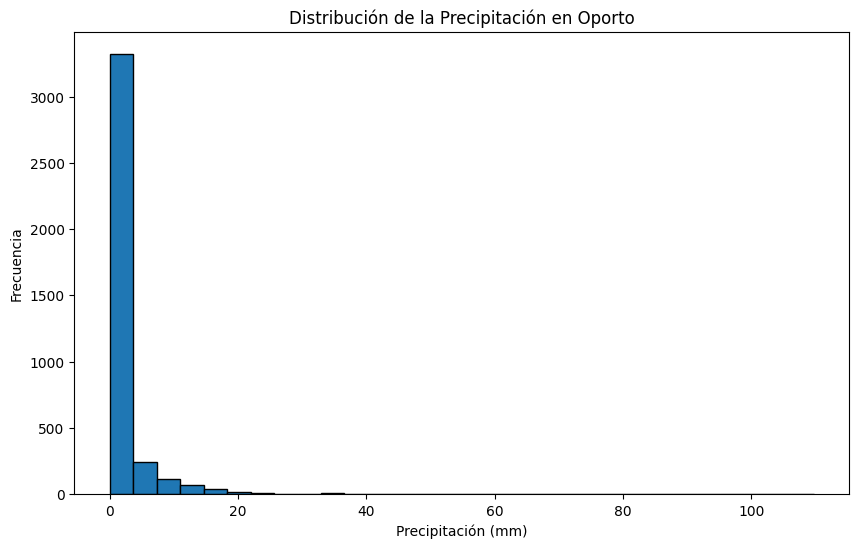

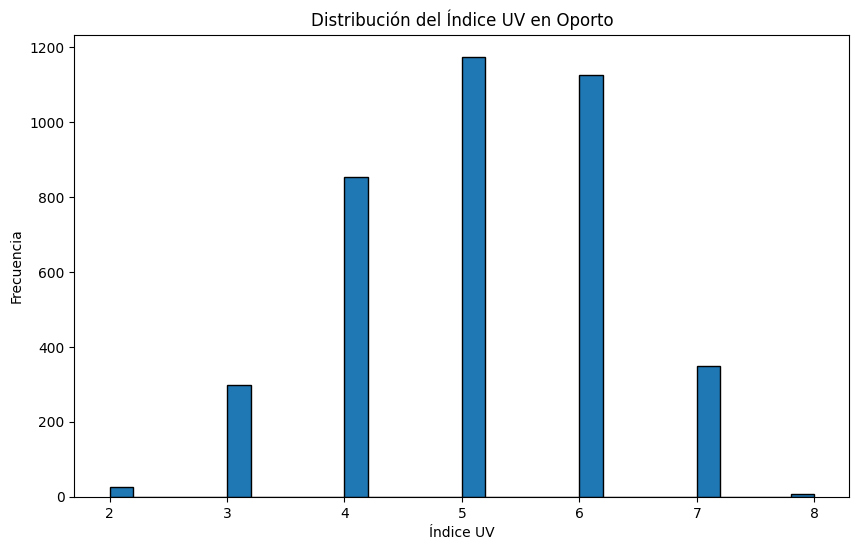

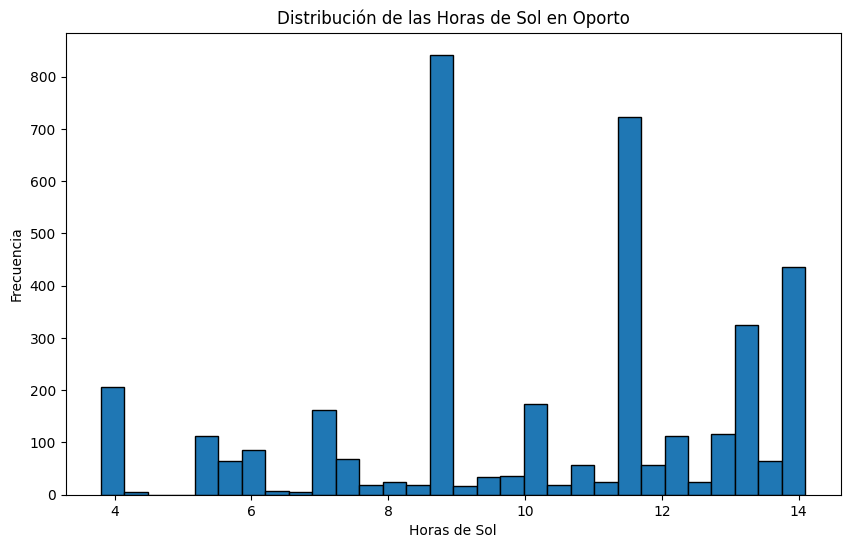

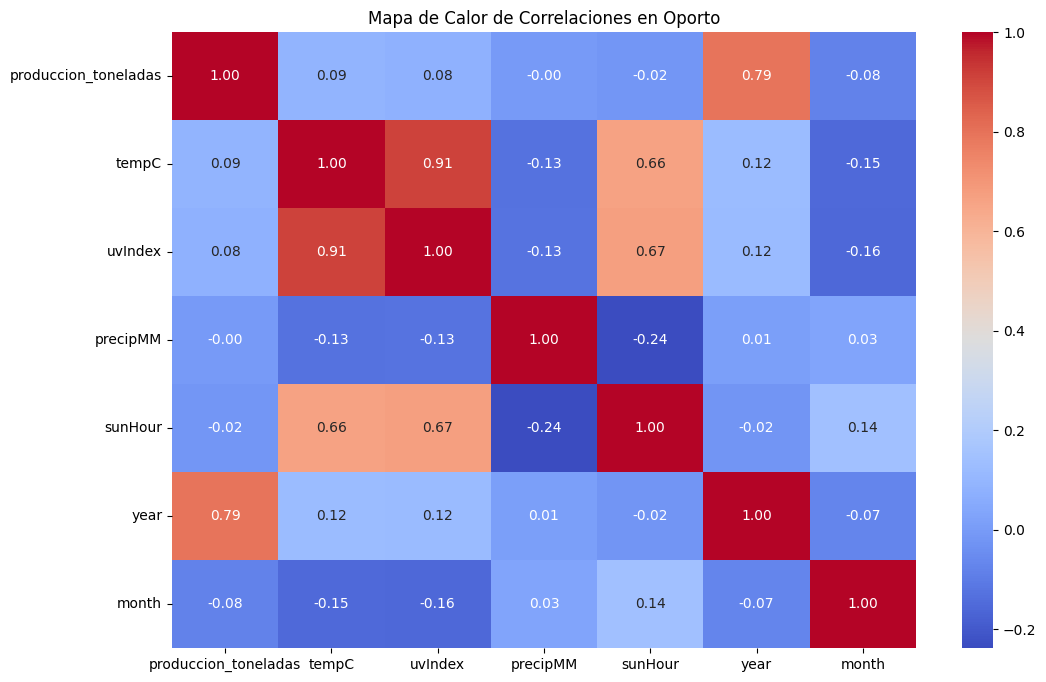

Análisis descriptivo para Lisboa:
                              date_y  produccion_toneladas        tempC  \
count                           3836            3836.00000  3836.000000   
mean   2013-09-30 11:59:59.999999744            2942.81804    20.519812   
min              2008-07-01 00:00:00            2800.00000     8.000000   
25%              2011-02-14 18:00:00            2900.00000    16.000000   
50%              2013-09-30 12:00:00            2950.00000    20.000000   
75%              2016-05-16 06:00:00            3000.00000    25.000000   
max              2018-12-31 00:00:00            3100.00000    40.000000   
std                              NaN              72.88010     5.310576   

           uvIndex     precipMM      sunHour         year        month  
count  3836.000000  3836.000000  3836.000000  3836.000000  3836.000000  
mean      4.677268     0.847080    10.604458  2013.236444     6.666058  
min       2.000000     0.000000     4.800000  2008.000000     1.000000 

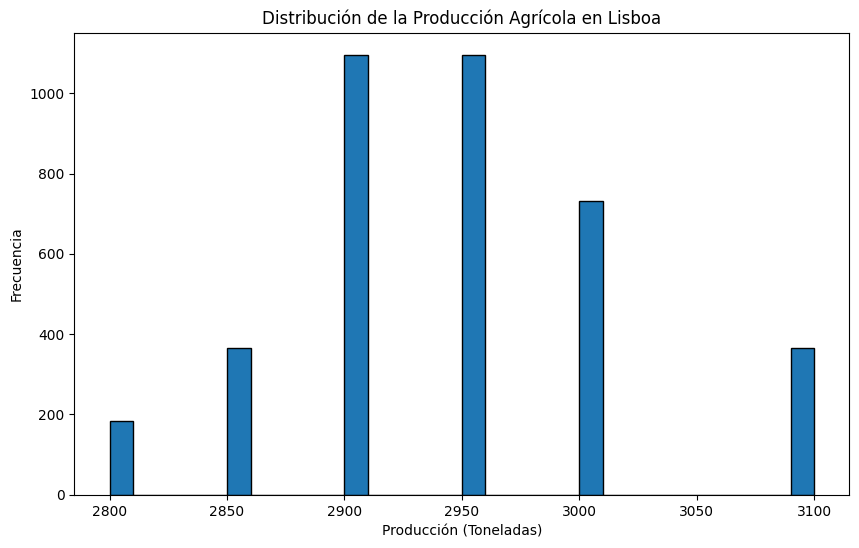

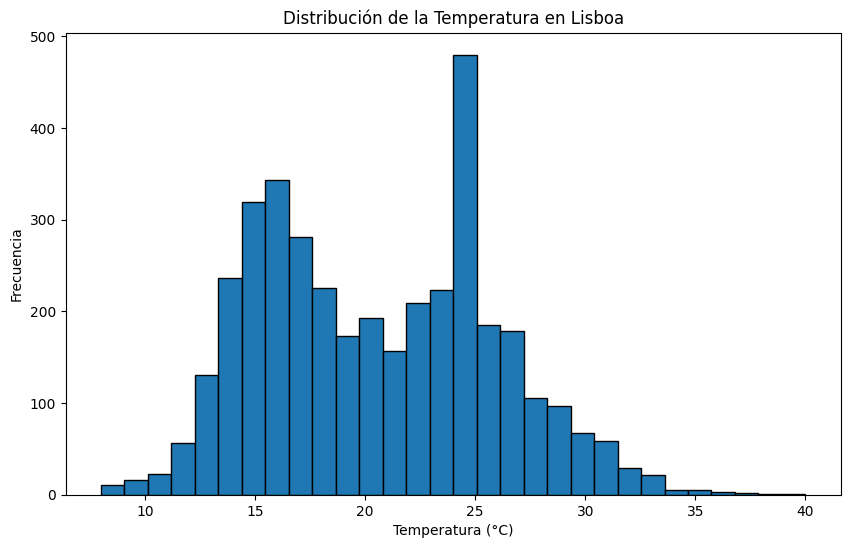

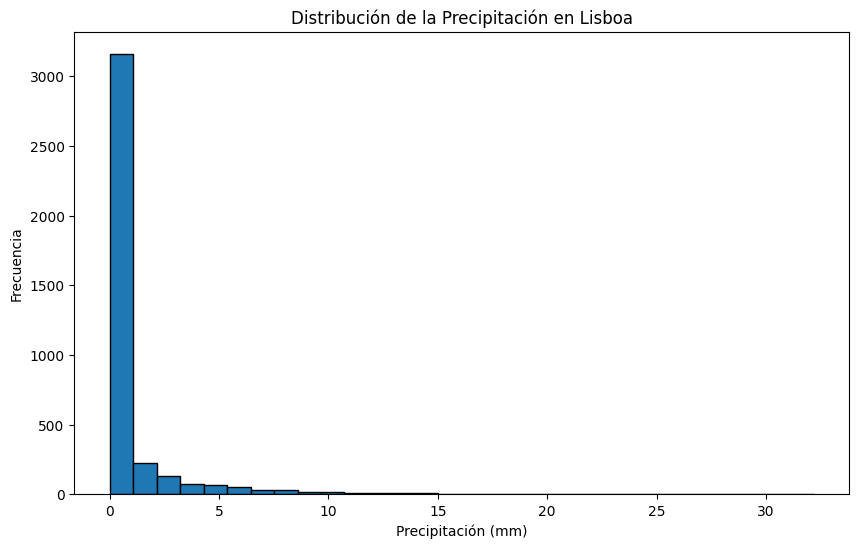

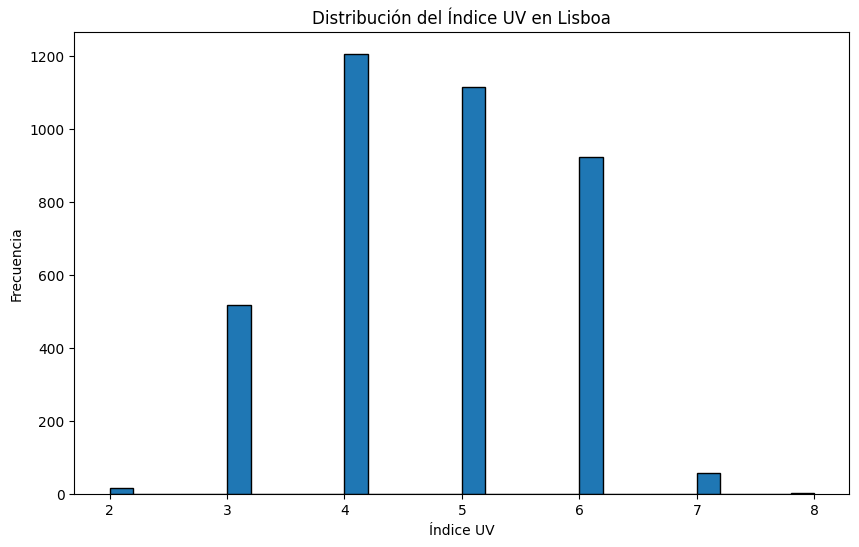

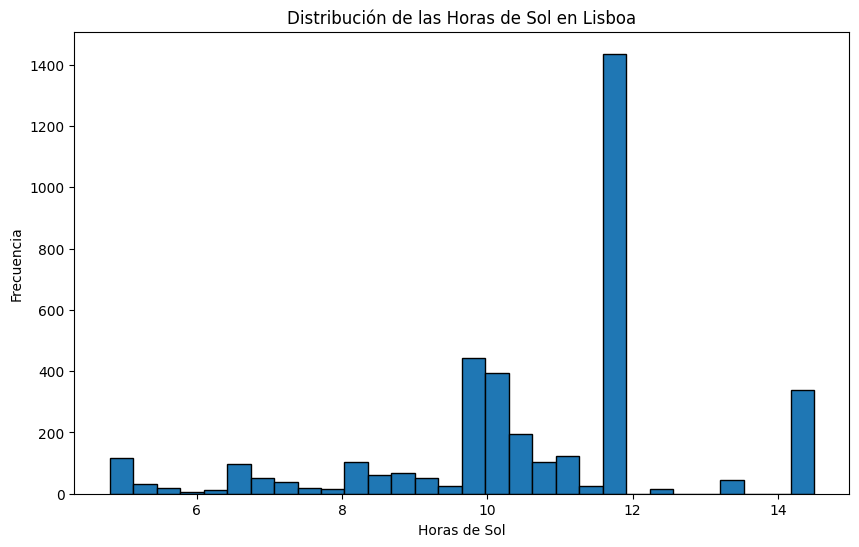

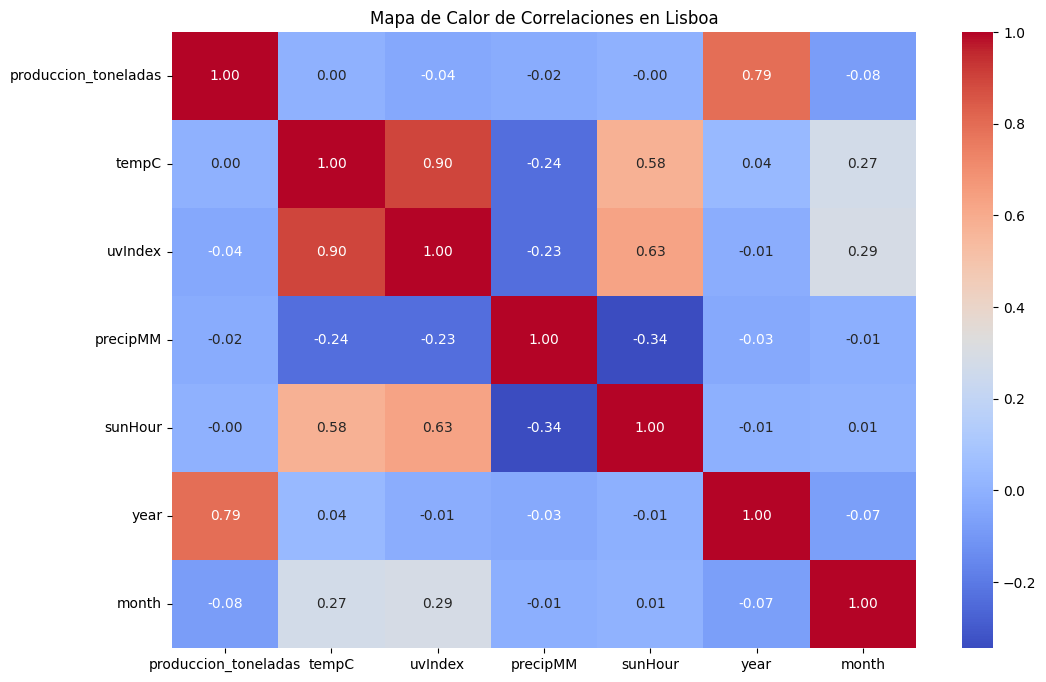

In [10]:
# Análisis descriptivo de las variables agrícolas
print("Análisis descriptivo de las variables agrícolas:")
print(agri_df.describe())

# Análisis descriptivo de las variables meteorológicas
print("Análisis descriptivo de las variables meteorológicas:")
print(weather_df.describe())

# Realizar análisis por ciudad
ciudades = data['ciudad'].unique()
for ciudad in ciudades:
    ciudad_data = data[data['ciudad'] == ciudad]
    
    print(f"Análisis descriptivo para {ciudad.capitalize()}:")
    print(ciudad_data.describe())
    
    # Visualización de la producción agrícola
    plt.figure(figsize=(10, 6))
    plt.hist(ciudad_data['produccion_toneladas'], bins=30, edgecolor='k')
    plt.title(f'Distribución de la Producción Agrícola en {ciudad.capitalize()}')
    plt.xlabel('Producción (Toneladas)')
    plt.ylabel('Frecuencia')
    plt.show()
    
    # Visualización de la temperatura
    plt.figure(figsize=(10, 6))
    plt.hist(ciudad_data['tempC'], bins=30, edgecolor='k')
    plt.title(f'Distribución de la Temperatura en {ciudad.capitalize()}')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Frecuencia')
    plt.show()
    
    # Visualización de la precipitación
    plt.figure(figsize=(10, 6))
    plt.hist(ciudad_data['precipMM'], bins=30, edgecolor='k')
    plt.title(f'Distribución de la Precipitación en {ciudad.capitalize()}')
    plt.xlabel('Precipitación (mm)')
    plt.ylabel('Frecuencia')
    plt.show()
    
    # Visualización de la radiación UV
    plt.figure(figsize=(10, 6))
    plt.hist(ciudad_data['uvIndex'], bins=30, edgecolor='k')
    plt.title(f'Distribución del Índice UV en {ciudad.capitalize()}')
    plt.xlabel('Índice UV')
    plt.ylabel('Frecuencia')
    plt.show()
    
    # Visualización de las horas de sol
    plt.figure(figsize=(10, 6))
    plt.hist(ciudad_data['sunHour'], bins=30, edgecolor='k')
    plt.title(f'Distribución de las Horas de Sol en {ciudad.capitalize()}')
    plt.xlabel('Horas de Sol')
    plt.ylabel('Frecuencia')
    plt.show()

    # Filtrar solo columnas numéricas para la correlación
    numeric_columns = ciudad_data.select_dtypes(include=[float, int]).columns
    numeric_data = ciudad_data[numeric_columns]
    
    # Visualización de correlaciones entre variables meteorológicas y la producción agrícola
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Mapa de Calor de Correlaciones en {ciudad.capitalize()}')
    plt.show()


### Análisis de Resultados

#### Resultados del Análisis Descriptivo y Visualización

El análisis descriptivo y las visualizaciones nos proporcionan una visión general de la distribución de las variables en cada ciudad, así como de las relaciones entre las variables meteorológicas y la producción agrícola. A continuación, se presentan los puntos clave para cada ciudad:

#### Madrid

1. **Producción Agrícola**:
   - La distribución de la producción agrícola muestra una variabilidad considerable en las toneladas producidas.
   
2. **Temperatura**:
   - La temperatura varía significativamente a lo largo del año, con una distribución centrada alrededor de una media específica.

3. **Precipitación**:
   - La distribución de la precipitación muestra que hay periodos de baja y alta precipitación.
   
4. **Índice UV**:
   - La distribución del índice UV indica variaciones moderadas a lo largo del año.
   
5. **Horas de Sol**:
   - La distribución de las horas de sol es bastante consistente, con algunas variaciones estacionales.

6. **Mapa de Calor de Correlaciones**:
   - Las correlaciones entre las variables meteorológicas y la producción agrícola muestran algunas relaciones interesantes que pueden ser útiles para el modelado.


   -
#### Barcelona

1. **Producción Agrícola**:
   - Similar a Madrid, la producción agrícola en Barcelona muestra una variabilidad considerable en las toneladas producidas.
   
2. **Temperatura**:
   - La temperatura en Barcelona muestra una distribución con una media ligeramente diferente a la de Madrid.

3. **Precipitación**:
   - La distribución de la precipitación en Barcelona es diferente, mostrando un patrón distinto.
   
4. **Índice UV**:
   - El índice UV en Barcelona también muestra variaciones a lo largo del año, con una distribución específica.
   
5. **Horas de Sol**:
   - Las horas de sol en Barcelona presentan una distribución similar a la de Madrid, pero con algunas diferencias estacionales.

6. **Mapa de Calor de Correlaciones**:
   - Las correlaciones en Barcelona destacan algunas relaciones únicas entre las variables meteorológicas y la producción agrícola que pueden influir en el modelado.

#### Sevilla

1. **Producción Agrícola**:
   - Sevilla muestra una distribución de producción agrícola con variaciones significativas en las toneladas producidas.
   
2. **Temperatura**:
   - La temperatura en Sevilla tiene una distribución diferente a la de Madrid y Barcelona, con una media distinta.

3. **Precipitación**:
   - La precipitación en Sevilla muestra un patrón único con periodos de alta y baja precipitación.
   
4. **Índice UV**:
   - El índice UV en Sevilla tiene una distribución que varía moderadamente a lo largo del año.
   
5. **Horas de Sol**:
   - La distribución de las horas de sol en Sevilla muestra algunas variaciones estacionales.

6. **Mapa de Calor de Correlaciones**:
   - Las correlaciones en Sevilla destacan algunas relaciones únicas entre las variables meteorológicas y la producción agrícola que son relevantes para el modelado.

#### Valencia

1. **Producción Agrícola**:
   - Valencia presenta una variabilidad considerable en la producción agrícola.
   
2. **Temperatura**:
   - La temperatura en Valencia tiene una distribución específica, diferente de las otras ciudades.

3. **Precipitación**:
   - La precipitación en Valencia muestra un patrón único, con variaciones en diferentes periodos.
   
4. **Índice UV**:
   - El índice UV en Valencia tiene una distribución que varía a lo largo del año.
   
5. **Horas de Sol**:
   - Las horas de sol en Valencia presentan variaciones estacionales.

6. **Mapa de Calor de Correlaciones**:
   - Las correlaciones en Valencia muestran algunas relaciones importantes entre las variables meteorológicas y la producción agrícola que pueden ser útiles para el modelado.

#### Bilbao

1. **Producción Agrícola**:
   - La producción agrícola en Bilbao muestra una variabilidad considerable.
   
2. **Temperatura**:
   - La temperatura en Bilbao tiene una distribución distinta de las otras ciudades.

3. **Precipitación**:
   - La precipitación en Bilbao muestra un patrón específico con variaciones en diferentes periodos.
   
4. **Índice UV**:
   - El índice UV en Bilbao varía moderadamente a lo largo del año.
   
5. **Horas de Sol**:
   - Las horas de sol en Bilbao muestran variaciones estacionales.

6. **Mapa de Calor de Correlaciones**:
   - Las correlaciones en Bilbao destacan algunas relaciones únicas entre las variables meteorológicas y la producción agrícola que son relevantes para el modelado.


## Conclusiones
El análisis descriptivo y la visualización de datos en las ciudades seleccionadas muestran que cada ciudad tiene patrones únicos en sus variables meteorológicas y de producción agrícola. Estos patrones influyen en las correlaciones observadas y, por tanto, en las estrategias de modelado que se pueden aplicar para predecir la producción agrícola en función de las condiciones climáticas.

## Preparación de Datos para Modelado

### 1. Normalización y Escalado de los Datos

Para mejorar el rendimiento de los modelos, especialmente los basados en distancias como KNN, es importante normalizar y escalar las variables predictoras.

In [11]:
# Seleccionar las columnas de interés para la normalización
features = ['tempC', 'uvIndex', 'precipMM', 'sunHour']

# Aplicar escalado estándar a las variables predictoras
scaler = StandardScaler()
monthly_means[features] = scaler.fit_transform(monthly_means[features])

# Verificar los primeros registros después de la normalización
print(monthly_means.head())

               ciudad  year  month     tempC   uvIndex  precipMM   sunHour  \
date                                                                         
2008-07-01  barcelona  2008      7  0.588902  0.964484 -0.772216  1.681842   
2008-07-01       vigo  2008      7  0.241624  0.190979 -0.546453  1.339026   
2008-07-01   valencia  2008      7  0.607931  0.732432  2.736932 -0.722209   
2008-07-01     lisboa  2008      7  0.484242  0.706649 -1.000433  1.017908   
2008-07-01    sevilla  2008      7  2.182575  1.815339 -1.000433  1.608072   

            produccion_toneladas  
date                              
2008-07-01                2500.0  
2008-07-01                1800.0  
2008-07-01                3500.0  
2008-07-01                2800.0  
2008-07-01                4000.0  


2. Creación de Nuevas Variables

Generar nuevas variables basadas en las existentes puede proporcionar más información a los modelos.

In [12]:
# Crear nuevas características basadas en interacciones y polinomios
monthly_means['tempc_squared'] = monthly_means['tempC'] ** 2
monthly_means['precipmm_log'] = np.log1p(monthly_means['precipMM'])

# Verificar las nuevas características
print(monthly_means[['tempc_squared', 'precipmm_log']].head())


            tempc_squared  precipmm_log
date                                   
2008-07-01       0.346805     -1.479357
2008-07-01       0.058382     -0.790655
2008-07-01       0.369580      1.318265
2008-07-01       0.234491           NaN
2008-07-01       4.763632           NaN


/home/vscode/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


3. Dividir los Datos en Conjuntos de Entrenamiento y Prueba

Es fundamental dividir los datos en conjuntos de entrenamiento y prueba para evaluar la capacidad de generalización del modelo.

In [13]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(monthly_means) * 0.8)
train, test = train_test_split(monthly_means, train_size=train_size, shuffle=False)

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print(f'Tamaño del conjunto de entrenamiento: {train.shape}')
print(f'Tamaño del conjunto de prueba: {test.shape}')


Tamaño del conjunto de entrenamiento: (806, 10)
Tamaño del conjunto de prueba: (202, 10)


4. Análisis de Estacionariedad y Diferenciación

Para los modelos de series temporales como SARIMAX, es importante asegurar que los datos sean estacionarios.

In [14]:
# Realizar la prueba de Dickey-Fuller Aumentada
result = adfuller(train['produccion_toneladas'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Si el p-valor es mayor a 0.05, diferenciar los datos
if result[1] > 0.05:
    train['produccion_toneladas_diff'] = train['produccion_toneladas'].diff().dropna()
    test['produccion_toneladas_diff'] = test['produccion_toneladas'].diff().dropna()
    print('Datos diferenciados para estacionariedad.')
else:
    print('Datos ya son estacionarios.')

ADF Statistic: -14.486222783471268
p-value: 6.2547062491560776e-27
Datos ya son estacionarios.


## Modelado

### 1. Modelo SARIMAX

SARIMAX es adecuado para datos de series temporales que incluyen componentes estacionales y exógenos. Vamos a entrenar este modelo utilizando las variables meteorológicas como predictores exógenos.

In [15]:
# Definir y entrenar el modelo SARIMAX
model_sarimax = SARIMAX(train['produccion_toneladas_diff'].dropna() if 'produccion_toneladas_diff' in train.columns else train['produccion_toneladas'],
                        exog=train[['tempC', 'uvIndex', 'precipMM', 'sunHour']],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12))

model_fit_sarimax = model_sarimax.fit(disp=False)

# Hacer predicciones con SARIMAX
test_exog = test[['tempC', 'uvIndex', 'precipMM', 'sunHour']]
predictions_sarimax = model_fit_sarimax.predict(start=len(train), end=len(train) + len(test) - 1, exog=test_exog)

# Evaluar el modelo SARIMAX utilizando el RMSE
from sklearn.metrics import mean_squared_error

mse_sarimax = mean_squared_error(test['produccion_toneladas'], predictions_sarimax)
rmse_sarimax = mse_sarimax ** 0.5

print(f'RMSE del modelo SARIMAX: {rmse_sarimax}')

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE del modelo SARIMAX: 556.3683300145166


/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### 2. Modelo Random Forest

Random Forest es un modelo robusto para datos estructurados y puede manejar no linealidades y interacciones complejas entre variables.

In [16]:
# Preparar datos para el modelo Random Forest
features = ['tempC', 'uvIndex', 'precipMM', 'sunHour', 'tempc_squared', 'precipmm_log']
X_train = train[features]
y_train = train['produccion_toneladas']
X_test = test[features]
y_test = test['produccion_toneladas']

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)

# Hacer predicciones con Random Forest
predictions_rf = model_rf.predict(X_test_scaled)

# Evaluar el modelo Random Forest utilizando el RMSE
mse_rf = mean_squared_error(y_test, predictions_rf)
rmse_rf = mse_rf ** 0.5
print(f"RMSE del modelo Random Forest: {rmse_rf}")

RMSE del modelo Random Forest: 474.5724274137575


### 3. Modelo K-Nearest Neighbors (KNN)
KNN es un modelo simple pero poderoso que predice valores basados en la proximidad de los puntos de datos.

In [17]:
# Imputar valores nulos con la media
imputer = SimpleImputer(strategy='mean')

# Ajustar el imputer a los datos de entrenamiento y transformar
X_train_imputed = imputer.fit_transform(X_train_scaled)
# Transformar los datos de prueba
X_test_imputed = imputer.transform(X_test_scaled)

# Entrenar y evaluar el modelo KNN
model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train_imputed, y_train)

# Hacer predicciones con KNN
predictions_knn = model_knn.predict(X_test_imputed)

# Evaluar el modelo KNN utilizando el RMSE
mse_knn = mean_squared_error(y_test, predictions_knn)
rmse_knn = mse_knn ** 0.5
print(f"RMSE del modelo KNN: {rmse_knn}")

RMSE del modelo KNN: 513.8791513363992


### Comparación de los modelos:
- RMSE del modelo SARIMAX: 556.37
- RMSE del modelo Random Forest: 474.57
- RMSE del modelo KNN: 513.88
## Interpretación:
Random Forest tiene el RMSE más bajo (474.57), lo que sugiere que es el modelo más preciso entre los tres para este conjunto de datos.
KNN tiene un RMSE intermedio (513.88), lo que lo hace más preciso que SARIMAX pero menos preciso que Random Forest.
SARIMAX tiene el RMSE más alto (556.37), lo que indica que, de los tres modelos, sus predicciones son las menos precisas.

In [18]:
# Seleccionamos el modelo Random Forest ya que tiene el RMSE mas bajo
best_model = RandomForestRegressor()
best_model.fit(X_train, y_train)


RandomForestRegressor()

### Despliegue del Modelo
Guardar el Mejor Modelo

Después de haber evaluado y seleccionado el mejor modelo para la predicción de la producción agrícola, procedemos a su serialización para garantizar su reutilización en la aplicación web.

In [19]:
import joblib

# Serializar y guardar el modelo entrenado
joblib.dump(best_model, 'best_model.pkl')

# Guardar el scaler si se utilizó uno durante la fase de preprocesamiento
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

### En este paso:

- Serialización del Modelo: Hemos utilizado la biblioteca joblib para serializar y guardar el modelo entrenado. Esto es fundamental para preservar el estado del modelo, lo que permite reutilizarlo para hacer predicciones sin necesidad de entrenarlo nuevamente.
- Guardar el Scaler: Si se aplicó un escalado a las características antes del entrenamiento, también guardamos el scaler para asegurarnos de que los nuevos datos de entrada se transformen de la misma manera.

## Creación de la Aplicación Web
### Configurar Streamlit
La interfaz de usuario será desarrollada utilizando Streamlit, permitiendo que los usuarios ingresen nuevas características climáticas para obtener predicciones de producción agrícola en tiempo real.



In [20]:
import streamlit as st

# Cargar el modelo y el escalador
model = joblib.load('best_model.pkl')
scaler = joblib.load('scaler.pkl')

# Título de la aplicación
st.title('Predicción de Producción Agrícola')

# Entradas del usuario
temp = st.number_input('Temperatura (C°)')
uv_index = st.number_input('Índice UV')
precip_mm = st.number_input('Precipitación (mm)')
sun_hours = st.number_input('Horas de Sol')

# Preparar las características adicionales necesarias para el escalador
tempc_squared = temp ** 2
precipmm_log = np.log1p(precip_mm)  # Logaritmo natural de 1 + precipitación

# Crear el DataFrame de entrada con todas las características esperadas
input_data = pd.DataFrame([[temp, uv_index, precip_mm, sun_hours, tempc_squared, precipmm_log]], 
                          columns=['tempC', 'uvIndex', 'precipMM', 'sunHour', 'tempc_squared', 'precipmm_log'])

# Escalar los datos de entrada utilizando el scaler previamente ajustado
input_data_scaled = scaler.transform(input_data)

# Realizar la predicción
prediction = model.predict(input_data_scaled)

# Mostrar la predicción
st.write(f'Producción estimada: {prediction[0]} toneladas')

2024-08-12 16:13:09.997 
  command:

    streamlit run /home/vscode/.local/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-08-12 16:13:09.998 Session state does not function when running a script without `streamlit run`
/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
